# Solving Time-Dependent PDEs

Created: 18 June 2021 <br/>
Last edited: 18 June 2021 <br/>
Teng-Jui Lin

Content adapted from UW CHEME 375, Chemical Engineering Computer Skills, in Spring 2021.

In this notebook, we explore the implementation of

- solving time-dependent PDEs using finite difference method


## Time-dependent 1D heat transfer
**Problem Statement.** Determine the temperature profile of a thin insulated rod with two fixed temperatures at each end with a starting temperature after 1 min of time. 

The temperature at its extremes are $T_{H} = 120 \mathrm{^\circ C}$ and $T_L = 60 \mathrm{^\circ C}$. The initial temperature is $T_{i} = 20 \mathrm{^\circ C}$. The rod is $20 \ \mathrm{cm}$ long.

Explore the temperature profile of different materials. Given the material properties from [The Engineering ToolBox](https://www.engineeringtoolbox.com/):

|Material|Volumetric Mass Density <br/> $\rho \ [\times 10^3 \ \mathrm{kg/m^{3}}]$|Constant Volume Heat capacity <br/> $C_V \ [\times 10^3 \ \mathrm{J kg^{-1} K^{-1}}]$|Thermal conductivity <br/> $k \ [\mathrm{J m^{-1} s^{-1} K^{-1}}]$|
|-:|---:|-:|-:|
|Graphite|0.641 [[1]](https://www.engineeringtoolbox.com/density-materials-d_1652.html)|0.71 [[3]](https://www.engineeringtoolbox.com/specific-heat-solids-d_154.html)|168 [[4]](https://www.engineeringtoolbox.com/thermal-conductivity-d_429.html)|
|Titanium|4.5 [[2]](https://www.engineeringtoolbox.com/density-solids-d_1265.html)|0.47 [[3]](https://www.engineeringtoolbox.com/specific-heat-solids-d_154.html)|20.4 [[5]](https://www.engineeringtoolbox.com/thermal-conductivity-metals-d_858.html)|
|Gold|19.29 [[2]](https://www.engineeringtoolbox.com/density-solids-d_1265.html)|0.13 [[3]](https://www.engineeringtoolbox.com/specific-heat-solids-d_154.html)|312 [[5]](https://www.engineeringtoolbox.com/thermal-conductivity-metals-d_858.html)|

### Analytic expression
**Solution.** We have the heat transport governing equation

$$
k\nabla^2 T + \dot{q} + \Phi = \rho C_V\dfrac{\partial T}{\partial t}
$$

where $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$.

Based on the problem statement, we have the assumptions:

- No heat source/generation, insulated system
  - $\dot{q} = 0$
- No fluid or heat movement
  - $\Phi = 0$
- Thin rod $\implies$ 1D heat transfer (no heat transfer in $y, z$ directions)
  - $\frac{\partial^2 T}{\partial y^2} = 0, \frac{\partial^2 T}{\partial z^2} = 0$
- Constant thermal conductivity $\implies k \not= f(x, y, z, t)$
  - $k$ can be simplified

Therefore, we can simplify the governing equation:

$$
\begin{aligned}
k\nabla^2 T + \dot{q} + \Phi &= \rho C_V\dfrac{\partial T}{\partial t} \\
k\nabla^2 T &= \rho C_V\dfrac{\partial T}{\partial t} \\
k\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}\right) T &= \rho C_V\dfrac{\partial T}{\partial t} \\
k\frac{\partial^2T}{\partial x^2} &= \rho C_V\dfrac{\partial T}{\partial t}
\end{aligned}
$$

where $[k] = \mathrm{J m^{-1} s^{-1} K^{-1}}$ is the thermal conductivity, $[\rho] = \mathrm{kg/m^{3}}$ is the density, and $[C_V] = \mathrm{J kg^{-1} K^{-1}}$ is the heat capacity.

From the definition of coefficient of thermal diffusivity

$$
k_{td} = \dfrac{k}{\rho C_V},
$$

we can group the coefficients

$$
k_{td}\frac{\partial^2T}{\partial x^2} = \dfrac{\partial T}{\partial t}.
$$

### Numerical approximations
We approximate the derivatives by central finite difference

$$
\dfrac{\partial^2 T}{\partial x^2} \approx \dfrac{T_{i-1}^{\tau} - 2T_{i}^{\tau} + T_{i+1}^{\tau}}{\Delta x^2}
$$

and forward finite difference

$$
\dfrac{\partial T}{\partial t} \approx \dfrac{T_{i}^{\tau} - T_{i}^{\tau+1}}{\Delta t},
$$

where $i$ is the position index, and $\tau$ is the time index. Substitute back to the analytic expression, we have

$$
k_{td}\dfrac{T_{i-1}^{\tau} - 2T_{i}^{\tau} + T_{i+1}^{\tau}}{\Delta x^2} = \dfrac{T_{i}^{\tau} - T_{i}^{\tau+1}}{\Delta t}.
$$

Rearrange, we have

$$
\begin{aligned}
T_{i}^{\tau+1} &= T_{i}^{\tau}+\left(\frac{k_{t d}\Delta t}{\Delta x^{2}}\right)\left(T_{i-1}^{\tau}-2 T_{i}^{\tau}+T_{i+1}^{\tau}\right) \\
T_{i}^{\tau+1} &= T_{i}^{\tau}+\alpha\left(T_{i-1}^{\tau}-2 T_{i}^{\tau}+T_{i+1}^{\tau}\right)
\end{aligned}
$$

where $\alpha = \dfrac{k_{t d}\Delta t}{\Delta x^{2}}$.

With this expression, we can iterate and find the temperature at points on the rod at increasing time.

### Implementation - define and calculate constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# numerical steps
dt = 0.1  # s
dx = 1  # cm

In [3]:
# position array
L = 20  # cm
length = np.arange(0, L+dx, dx)
n_len = len(length)

# time array
t = 1 * 60  # s
time = np.arange(0, t+dt, dt)
n_time = len(time)

In [4]:
# define boundary conditions
T_high = 120  # deg C
T_low = 60  # deg C

# define initial conditions
T_initial = 20  # deg C

In [5]:
# define material properties
# [thermal conductivity, density, heat capacity]
# [k, rho, CV]
# [J/(m s K), kg/m^3, J/(kg K)]

Cg = [168, 641, 0.71e3]  # carbon, graphite
Ti = [20.4, 4.5e3, 0.47e3]  # titanium
Au = [312, 19.29e3, 0.13e3]  # gold

In [6]:
def k_td(properties):
    '''calculate coefficient of thermal conductivity k_td'''
    k, rho, CV = properties
    return k / (rho * CV) * (100**2)  # convert to cm^2/s

In [7]:
def alpha(k_td, dt, dx):
    '''calculate alpha, a condensed coefficient defined above'''
    return k_td * dt / (dx**2)

In [8]:
# calculate k_td for each material
k_td_Cg = k_td(Cg)
k_td_Ti = k_td(Ti)
k_td_Au = k_td(Au)

# calculate alpha for each material
alpha_Cg = alpha(k_td_Cg, dt, dx)
alpha_Ti = alpha(k_td_Ti, dt, dx)
alpha_Au = alpha(k_td_Au, dt, dx)

In [9]:
# sanity check
print('Coefficients of thermal diffusivity (k_td) [cm^2/s]:')
print(f'Graphite: {k_td_Cg:0.2e}')
print(f'Titanium: {k_td_Ti:0.2e}')
print(f'Gold: {k_td_Au:0.2e}')

Coefficients of thermal diffusivity (k_td) [cm^2/s]:
Graphite: 3.69e+00
Titanium: 9.65e-02
Gold: 1.24e+00


**Analysis.** From the coefficients of thermal diffusivity, we can predict that the temperature of graphite will reach equilibrium faster than titanium and gold. Titanium will have least change in temperature over time because of its one order of magnitude smaller $k_{td}$. Gold will have temperature profile over time similar to graphite, but its change in temperature will be less.

### Implementation - numerical calculation

We use finite difference method to solve the temperature of the rod at one time. We then iterate the process to solve for temperature of the rod at different times.

In [10]:
def temp_profile(n_len, n_time, alpha, T_high, T_low):
    '''
    Calculates temperature profile as function of position and time.
    Rows represent positions; columns represent time.
    '''
    # define initial and boundary conditions
    T_matrix = np.zeros((n_time, n_len)) + T_initial
    T_matrix[:, 0] = T_high
    T_matrix[:, -1] = T_low
    
    # iterate to find PDE approximation solution
    for tau in range(n_time-1):
        for i in range(1, n_len-1):
            T_matrix[tau+1, i] = T_matrix[tau, i] + alpha*(T_matrix[tau, i-1] - 2*T_matrix[tau, i] + T_matrix[tau, i+1])
    return T_matrix

In [11]:
# calculate temperature profiles for each material
temp_profile_Cg = temp_profile(n_len, n_time, alpha_Cg, T_high, T_low)
temp_profile_Ti = temp_profile(n_len, n_time, alpha_Ti, T_high, T_low)
temp_profile_Au = temp_profile(n_len, n_time, alpha_Au, T_high, T_low)
temp_profiles = [temp_profile_Cg, temp_profile_Ti, temp_profile_Au]

### Implementation - 2D visualization

In [12]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'cm',
    'font.size': 18,
    
    'lines.linewidth': 2,
    
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,
    
    'figure.dpi': 80,
    
    'legend.framealpha': 1, 
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14
})

In [13]:
# color of plots
colors_Cg = plt.cm.autumn(np.linspace(1, 0, n_time))
colors_Ti = plt.cm.summer(np.linspace(1, 0, n_time))
colors_Au = plt.cm.winter(np.linspace(1, 0, n_time))
colors = [colors_Cg, colors_Ti, colors_Au]

labels = ['graphite', 'titanium', 'gold']

In [14]:
# quick test for result convergence
# for i in range(n_time):
#     plt.plot(length, temp_profile_Cg[i, :], c=colors_Cg[i])  

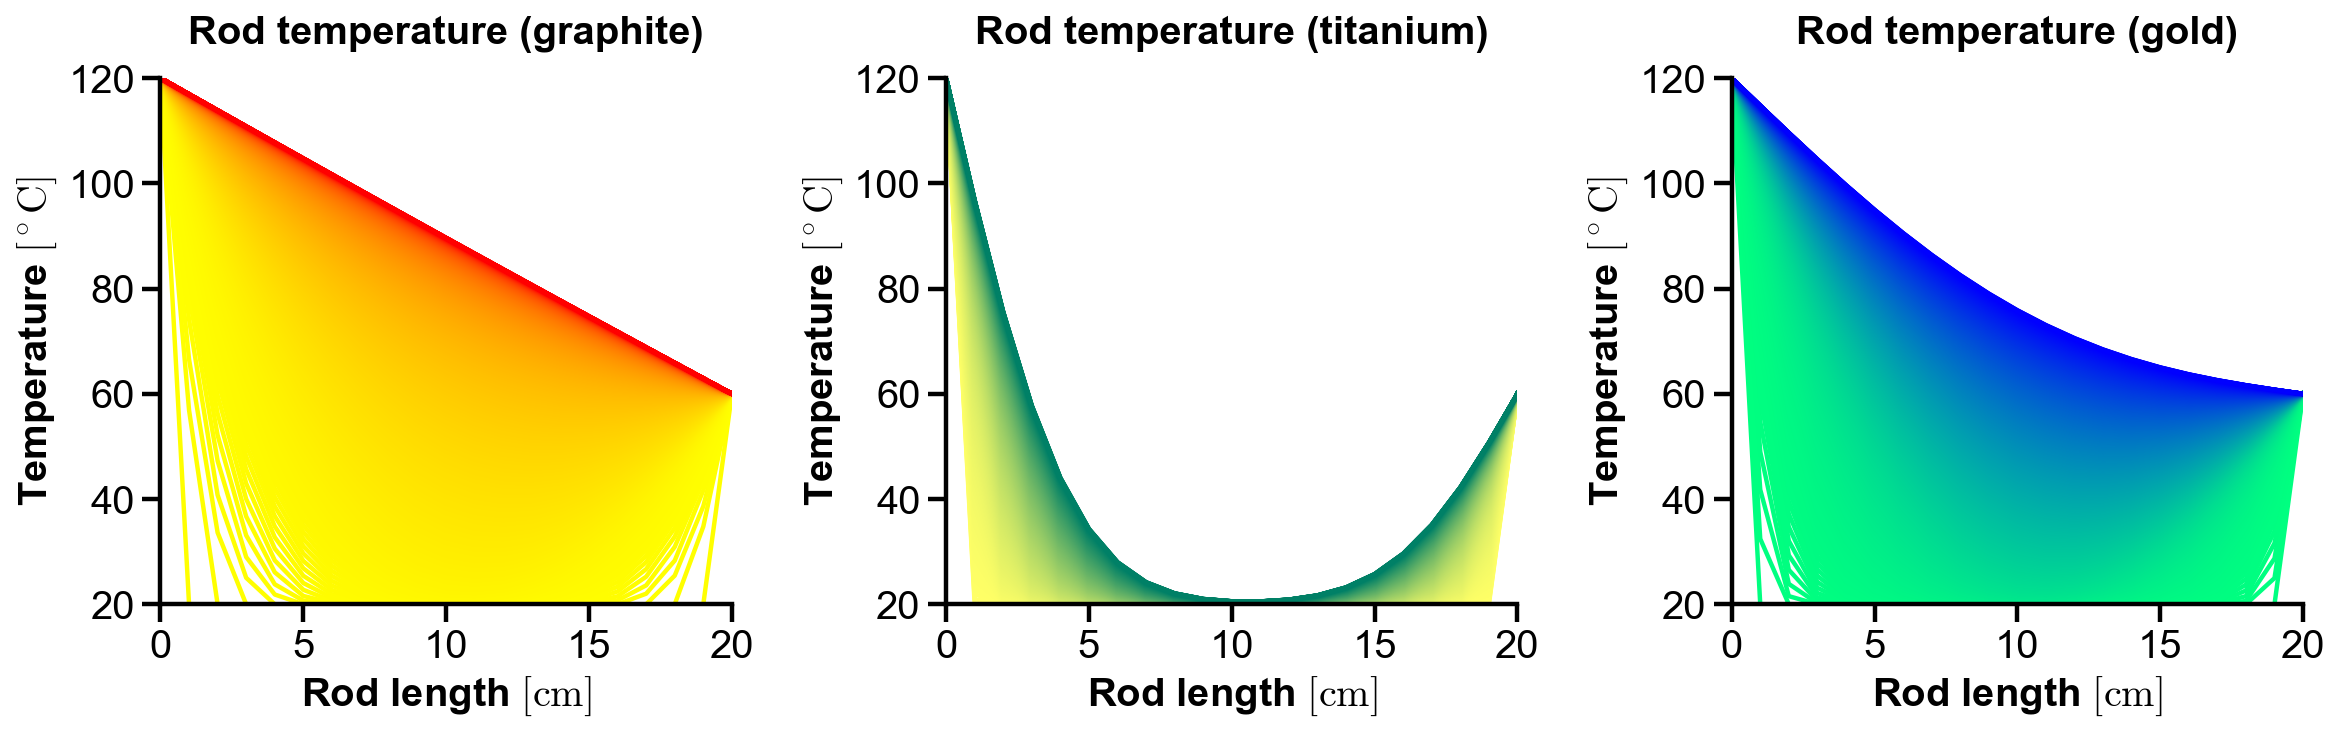

In [15]:
# plot 2d visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for j in range(3):
    for i in range(n_time):
        axs[j].plot(length, temp_profiles[j][i, :], c=colors[j][i])  
    axs[j].set_xlabel('Rod length $\mathrm{[cm]}$')
    axs[j].set_ylabel('Temperature $\mathrm{[^\circ C]}$')
    axs[j].set_title(f'Rod temperature ({labels[j]})', y=1.04)
    axs[j].set_xlim([0, L])
    axs[j].set_ylim([T_initial, T_high])
plt.tight_layout()

**Analysis.** As shown in the figure, the lighter colors indicate earlier times and darker colors indicate later times. Graphite with high coefficient of thermal diffusivity reaches equilibrium in the 1 min time frame. Gold with comparable coefficient of thermal diffusivity also have large change in temperature over time, but it has not reached equilibrium. Titanium with one magnitude lower coefficient of thermal diffusivity shows slow change in temperature over time. Only the temperature adjacent to the to ends have changed significantly, leaving the center unchanged within 1 min.

### Inplementation - 3D visualization

In [16]:
from mpl_toolkits.mplot3d import Axes3D

In [17]:
# define meshgrid for 3d visualization
length_mat, time_mat = np.meshgrid(length, time)

In [18]:
colors = [cm.autumn_r, cm.summer_r, cm.winter_r]

In [19]:
# %matplotlib qt  # interactive plotting
%matplotlib inline

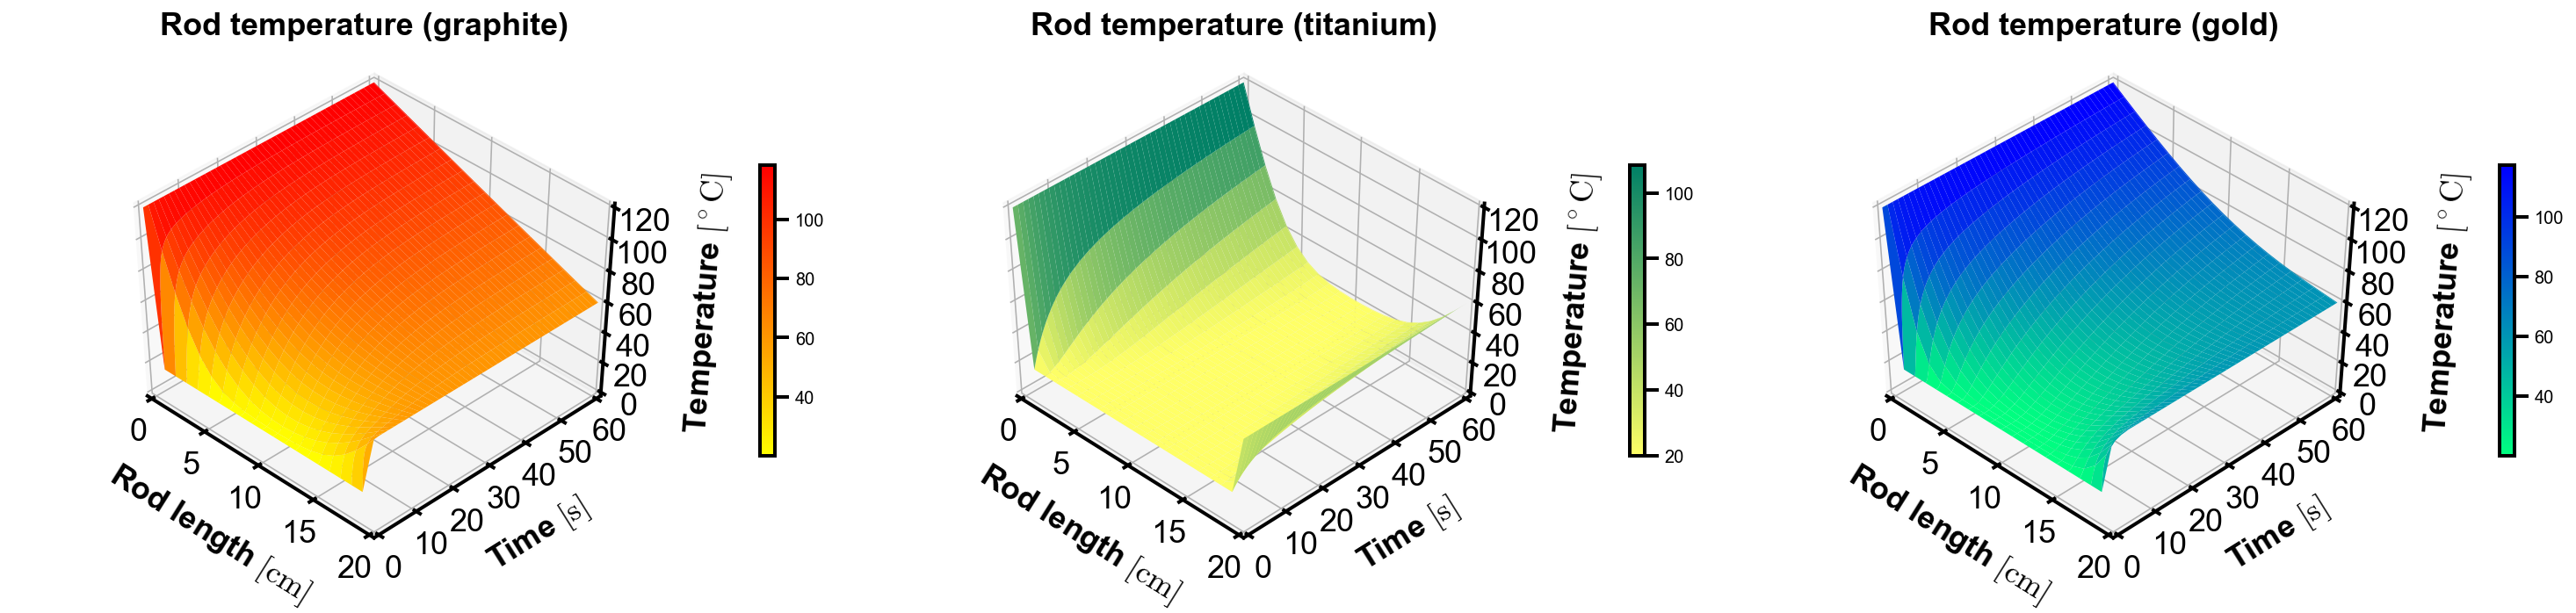

In [20]:
# plot 3d visualization
plt.rcParams.update({'xtick.labelsize': 18,})
fig, axs = plt.subplots(1, 3, figsize=(21, 5), subplot_kw={"projection": "3d"})
for j in range(3):
    surf = axs[j].plot_surface(length_mat, time_mat, temp_profiles[j], cmap=colors[j])  
    axs[j].set_xlabel('Rod length $\mathrm{[cm]}$', fontsize=18, labelpad=20)
    axs[j].set_ylabel('Time $\mathrm{[s]}$', fontsize=18, labelpad=20)
    axs[j].set_zlabel('Temperature $\mathrm{[^\circ C]}$', fontsize=18, labelpad=20)
    axs[j].set_title(f'Rod temperature ({labels[j]})', fontsize=18, y=1.04)
    axs[j].set_xlim([0, L])
    axs[j].set_ylim([0, t])
    axs[j].set_zlim([0, T_high])
    axs[j].view_init(45, -45)  # viewing angle
    axs[j].dist = 12  # zoom out to fit all labels in
    fig.colorbar(surf, shrink=0.5, ax=axs[j])

plt.tight_layout()  # subplot paddings

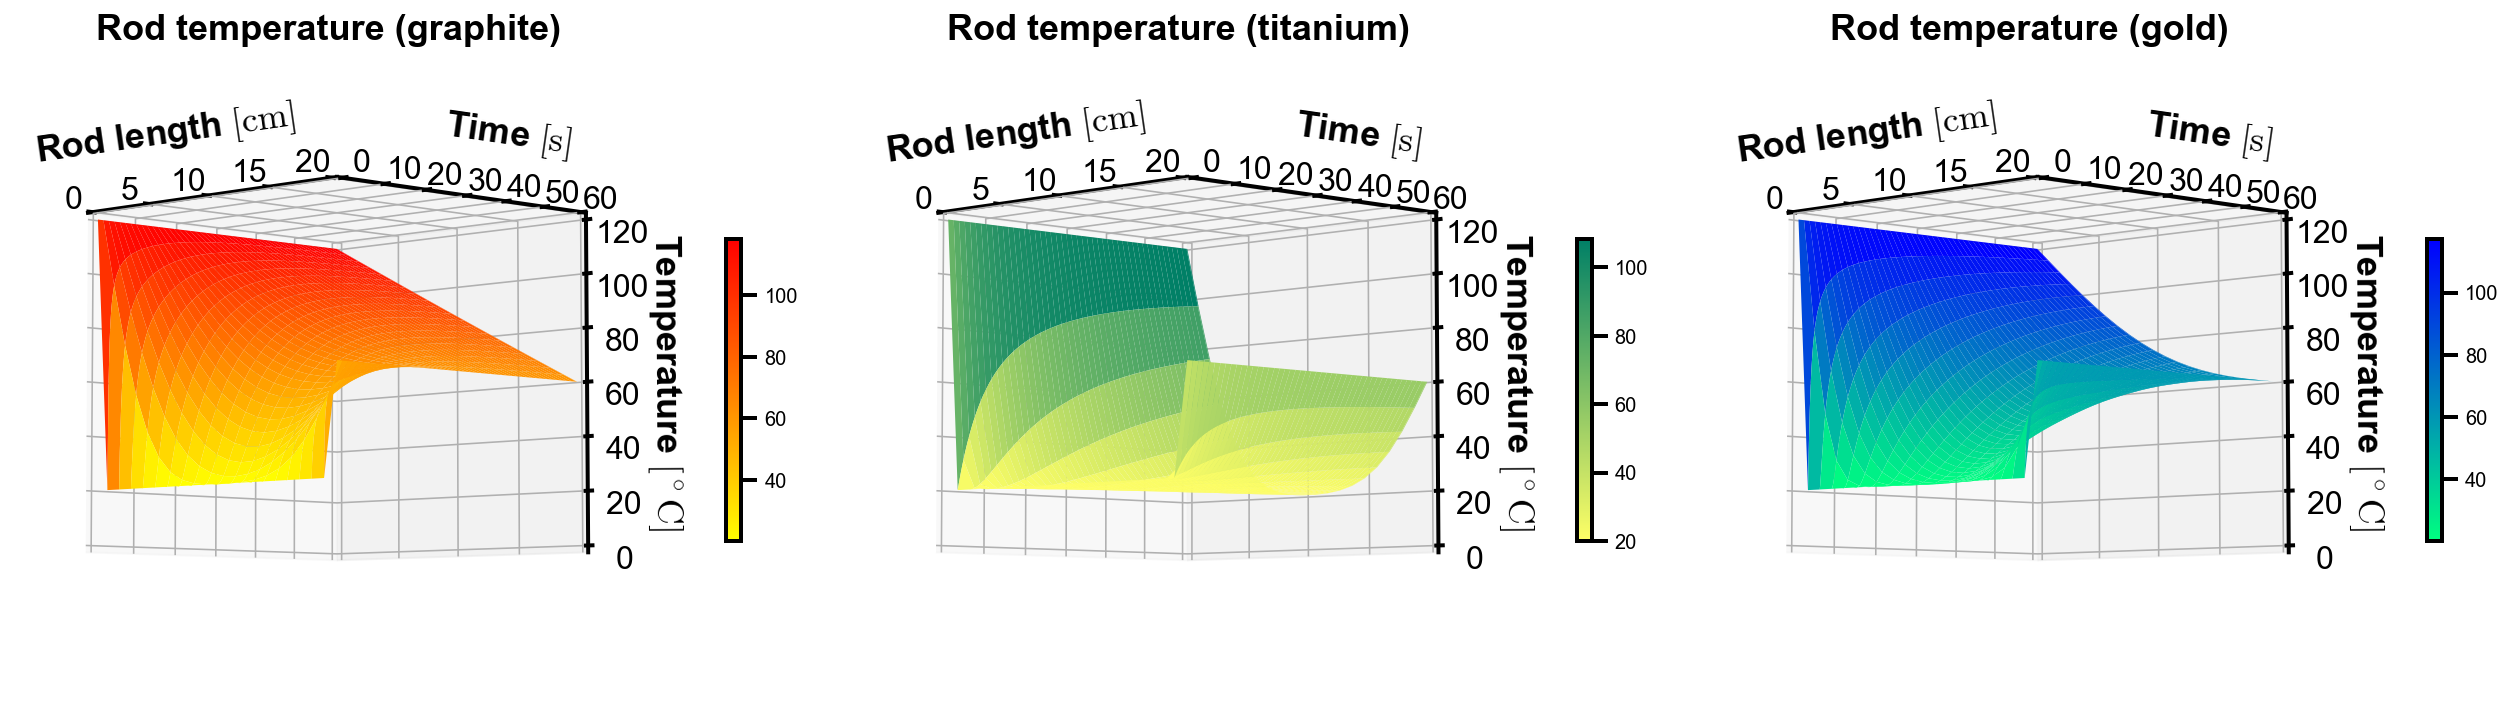

In [21]:
# plot 3d visualization from another angle
plt.rcParams.update({'xtick.labelsize': 16})
fig, axs = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={"projection": "3d"})
for j in range(3):
    surf = axs[j].plot_surface(length_mat, time_mat, temp_profiles[j], cmap=colors[j])  
    axs[j].set_xlabel('Rod length $\mathrm{[cm]}$', fontsize=18)
    axs[j].set_ylabel('Time $\mathrm{[s]}$', fontsize=18)
    axs[j].set_zlabel('Temperature $\mathrm{[^\circ C]}$', fontsize=18, labelpad=4)
    axs[j].set_title(f'Rod temperature ({labels[j]})', fontsize=18, y=1.15)
    axs[j].set_xlim([0, L])
    axs[j].set_ylim([0, t])
    axs[j].set_zlim([0, T_high])
    axs[j].view_init(-5, -45)  # viewing angle
    fig.colorbar(surf, shrink=0.5, ax=axs[j], pad=0.1)

plt.tight_layout()  # subplot paddings

**Analysis.** As shown in the figures, the lighter colors indicate lower temperature and darker colors indicate higher temperature. The temperature at the two ends are fixed, and the temperature in the middle increases over time. At final time, temperature of graphite increases the most, and titanium increases the least, being consistent with their coefficients of heat diffusivity.

The 3D plot is best when interactive mode is turned on, so that the user can rotate the diagram to see the surface in 3D. When presenting as a static image, it may not be ideal as details such as overlap and curves may be lost. For example, the curves are at initial times are not apparent in the first plot, but they can be viewed in the second plot.

### Comments on choice of visualization

Assuming the plots are used for static purposes, such as books, articles, and presentations, 2D visualization is more effective because 3D plot is unable to present the details of the shape of the surface in 2D static image, as explained above. The trend of the change in temperature over time is apparent in 2D plot, and the user can easily read off values from the final temperature curve. Nevertheless, 2D plot may have constraints on representing the time axis. As the amounts of points for time increases, the lines clusters together, making it impossible to read the temperature at a point at a specific time.

Assuming the plots are used for interactive purposes, such as interactive tutorials, where the plots can be rotated to fully visualize the surface shape (e.g. using `%matplotlib qt`), 3D visualization is more effective, as it gives a continuous description of how the temperature depends on the location of rod and the time of conduction. The use case, however, may be limited.